# SAÉ 2.04

## 0 - Connexion a la BDD

In [235]:
import psycopg
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy
from datetime import timedelta, datetime


# Connexion settings
conn_settings = {
  "host": "localhost",
  "dbname": "db",
  "user": "postgres",
  "password": "patate360",
  "port": 5432
}

conn = psycopg.connect(**conn_settings)

idSensor = 6 # Constant to select the sensor

In [236]:
# Check if the sensor exists in the database
sql = """
SELECT * FROM Sensor WHERE sensorid = %(id)s 
"""

param = {"id": idSensor}

with conn.execute(sql, param) as cur:
  row = cur.fetchone()
  if(row == None):
    raise Exception("No sensor associated with this id")

## 1 - Cartes de contrôle

In [237]:
"""
Get the last manual measurement for the selected sensor

:return: datetime with the last measure
"""
def getLastMeasure()->datetime: 
  sql = """
  SELECT max(controltimestamp) FROM controlMeasurement
  WHERE sensorid = %(id)s 
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

In [238]:
"""
Get the error values for the last 8 days up to a limit of 100 items, 
and if the number of items is less than 20, extend the period bayond 8 days.
Each error value is associated with the time the measurements were made

:return: list[tuple[float, datetime]] Each tuple contains the erreur value and the timestamp corresponding to the measurement time
"""
def getDataControlCard()->list[tuple[float, datetime]]: 
  # Used to retrieve values within an 8 days interval from the last measurement
  limitDays = getLastMeasure() - timedelta(days = 8)

  sql = """
  SELECT controlValue - sensorValue, cm.controltimestamp
  FROM ControlMeasurement cm
  JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
  WHERE cm.sensorid = %(id)s
  ORDER BY cm.controltimestamp DESC
  LIMIT 100
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    rows = []
    line = cur.fetchone()
    
    # Guarantee that we have at least 20 values to display
    while(line != None and (len(rows) < 20 or line[1] >= limitDays)):
      rows.append(line)
      line = cur.fetchone()

    # Reverse the list to have the data in the correct order
    rows.reverse()
    return rows

In [239]:
"""
Get the average of the erreur values

:return: float
"""
def getAvgErrorValue()->float:
  sql = """
    SELECT avg(controlValue - sensorValue)
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s;
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

In [240]:
"""
Get the standard deviation of the error values

:return: float
"""
def getStddevErrorValue()->float:
  sql = """
    SELECT stddev(controlValue - sensorValue)
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s;
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return cur.fetchone()[0]

In [241]:
# Show control chart
def showControlCard()->None:
  # Get data needed for display
  data = getDataControlCard()
  avg = getAvgErrorValue()
  stddev = getStddevErrorValue()
  print(stddev)

  # Format the data
  x = []
  y = []
  for el in data:
    y.append(el[0])
    x.append(el[1])

  # Show Data
  plt.figure(figsize=(12, 8))
  plt.plot(x, y, label='Datas')
  plt.plot([data[0][1], data[-1][1]], [avg, avg], label='Average')
  plt.plot([data[0][1], data[-1][1]], [avg + 2 * stddev, avg + 2 * stddev], c="Red", lw=2, label='Upper Control Limit')
  plt.plot([data[0][1], data[-1][1]], [avg - 2 * stddev, avg - 2 * stddev], c="Black", lw=2, label='Lower Control Limit')
  
  # Cosmetic
  plt.title('Control Chart')
  plt.xlabel('Time')
  plt.ylabel('Error measurement')
  plt.legend(bbox_to_anchor=(1, 1)) # Place the legend outside the chart
  plt.xticks(rotation=30) # For better readability

0.12276749191486094


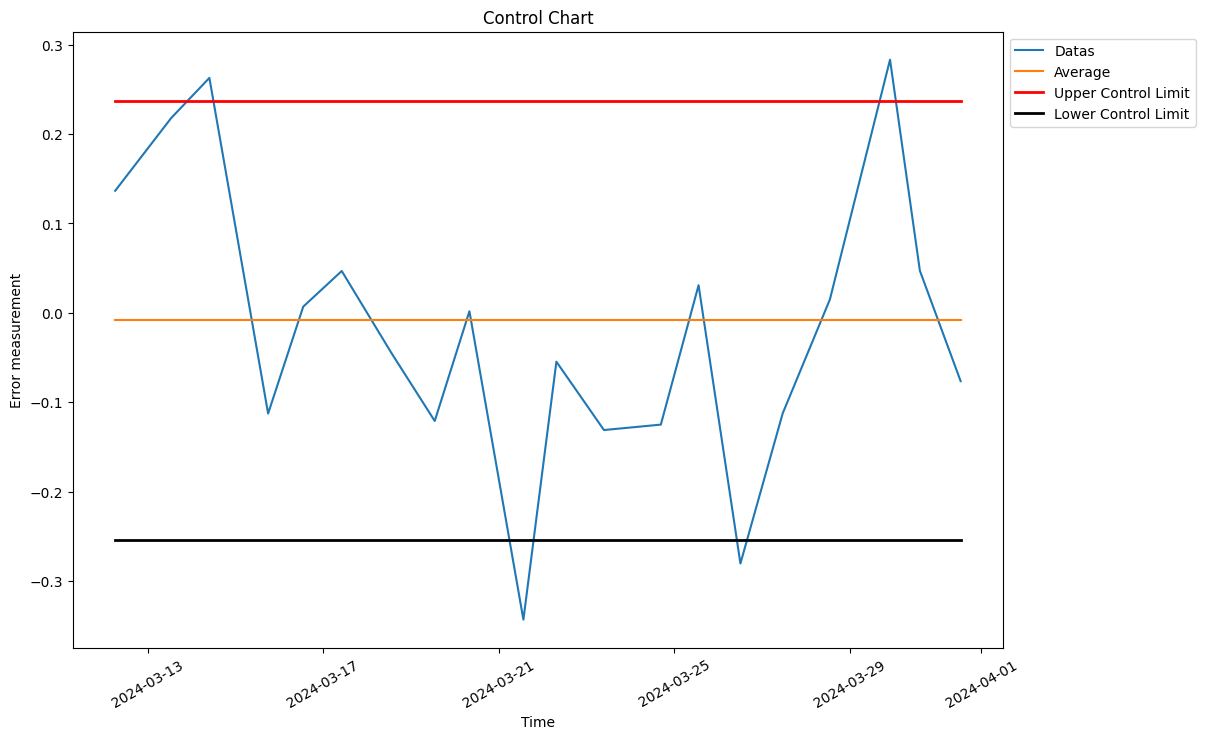

In [242]:
showControlCard()

## 2 - Statistiques
### 2.1 - Visualisation des marges d'erreur

In [243]:
"""
Get error values from the database

:return: list[float]
"""
def getErrorValues()->list[float]:
  sql = """
    SELECT controlValue - sensorValue
    FROM ControlMeasurement cm
    JOIN SensorMeasurement sm ON cm.sensorid = sm.sensorid AND cm.sensortimestamp = sm.timestamp
    WHERE cm.sensorid = %(id)s
  """

  param = {"id": idSensor}

  with conn.execute(sql, param) as cur:
    return [row[0] for row in cur]

In [244]:
"""
Calculate the distribution of values in a data set based on intervals defined by multiples of the standard deviation.

:data: list[float]
:factor: int, maximum multiple of the standard deviation to study

:return: list[float]
"""
def getDistributionByStdIntervals(data:list[float], factor:int)->list[float]:
  # Initialize a list of counters. The indexes correspond to intervals defined by multiples of the standard deviation.
  # The structure is organized as follows:
  # [ [-σ; 0], ]0; σ], ...,  [-factor*σ; -(factor+1)*σ[, ](factor-1)*σ; factor*σ], < -factor*σ, > factor*σ ]
  counts = [0 for _ in range(factor * 2 + 2)]

  std_dev = numpy.std(data)

  # Loops through the data values to distribute them into the corresponding intervals.
  for value in data:
    # Determines the index of the interval corresponding to the value based on the standard deviation.
    # The interval is calculated by taking the absolute value divided by the standard deviation.
    interval_index = int(abs(value) // std_dev)
    # Corrects the index to avoid errors due to exact divisions (if the value is a multiple of the standard deviation).
    if(abs(value) % std_dev == 0 and value != 0):
      interval_index -= 1

    # Updates the counter corresponding to the interval.
    # If the index exceeds the limit define by "factor", increment the counter of out-of-bounds values.
    if (interval_index >= factor):
      counts[-1 if value > 0 else -2] += 1
    else:
      counts[interval_index * 2 + (1 if value > 0 else 0)] += 1

  # Converts counts to percentages of the total data.
  # Organize the results in the following order:
  # [< -factor*σ, [-factor*σ; -(factor+1)*σ[, ..., [-σ; 0], ]0; σ], ..., ](factor-1)*σ; factor*σ], > factor*σ]
  percentages = []
  for i in range(len(counts) - 2, -1, -2):
    percentages.append(round(counts[i] / len(data) * 100, 2))
  for i in range(1, len(counts), 2):
    percentages.append(round(counts[i] / len(data) * 100, 2))

  return percentages

In [245]:
"""
Return the percentage of value included and excluded from the interval [-factor*σ; factor*σ] 

:distribution: list[float], obtained with the getDistributionByStdIntervals() function
:factor: int

:return: tuple[float, float] where the first element represents the proportion of values included in the interval and the second the proportion excluded
"""
def getPercentageInterval(distribution:list[float], factor:int)->tuple[float, float]:
  factor -= 1
  
  startNeg = len(distribution) // 2 - 1 - factor
  startPos = len(distribution) // 2 + factor

  res = 0

  while(startPos > startNeg):
    res += distribution[startNeg]
    res += distribution[startPos]

    startNeg += 1
    startPos -= 1

  return round(res, 2), round(100 - res, 2)

In [246]:
"""
Display the histogram of data distributions

:distribution: list[float], obtained with the getDistributionByStdIntervals() function
:factor: int
"""
def showDistribution(distribution:list[float], factor:int)->None:
  # Generate the labels
  labels = [str(-i) + 'σ' for i in range(factor, 0, -1)] + ['0'] + [str(i) + 'σ' for i in range(1, factor + 1)]

  # Generate nuanced colors based on percentage in the distribution
  norm = plt.Normalize(0, 100)
  base_color = mcolors.to_rgba('#135B8B')
  colors = [(base_color[0], base_color[1], base_color[2], min(1, norm(value) + 0.5)) for value in distribution]

  plt.figure(figsize=(12, 8))

  # Build the  histogram
  x_pos = [i for i in range(len(distribution))]
  plt.bar(x_pos, distribution, color=colors, width=1, align='edge')

  # Show percentages above bars
  for i, value in enumerate(distribution):
    plt.text(i + 0.5, value + 0.2, str(value) + '%', ha='center', va='bottom')

  # Label management
  x_pos = [i for i in range(1, len(distribution))]
  plt.xticks(ticks=x_pos, labels=labels)

Distribution: [0.0, 1.97, 16.67, 33.77, 32.24, 11.84, 3.51, 0.0] 100.0
Question 2.1.1: Dans l'intervale [-σ; σ], il y a 66.01% des points
	Question 2.1.4: En dehors de cet intervale, il y a 33.99% des points

Question 2.1.2: Dans l'intervale [-2σ; 2σ], il y a 94.52% des points
	Question 2.1.4: En dehors de cet intervale, il y a 5.48% des points

Question 2.1.3: Dans l'intervale [-3σ; 3σ], il y a 100.0% des points
	Question 2.1.4: En dehors de cet intervale, il y a 0.0% des points



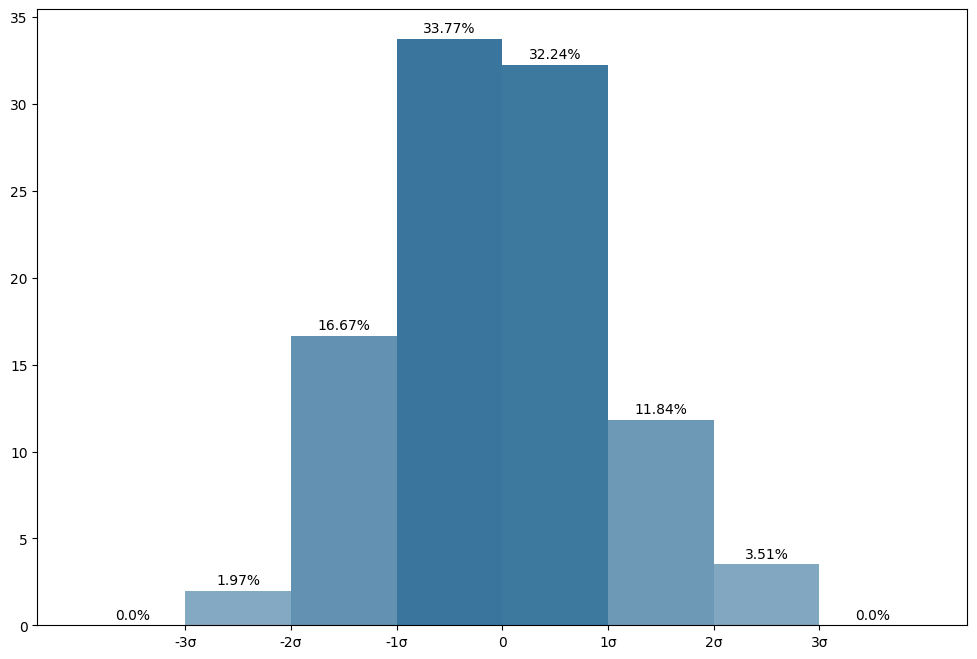

In [247]:
factor = 3
data = getErrorValues()
distribution = getDistributionByStdIntervals(data, factor)

showDistribution(distribution, factor)

print("Distribution:", distribution, sum(distribution))

res_q1 = getPercentageInterval(distribution, 1)
res_q2 = getPercentageInterval(distribution, 2)
res_q3 = getPercentageInterval(distribution, 3)

print("Question 2.1.1: Dans l'intervale [-σ; σ], il y a " + str(res_q1[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervale, il y a " + str(res_q1[1]) + "% des points\n")
print("Question 2.1.2: Dans l'intervale [-2σ; 2σ], il y a " + str(res_q2[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervale, il y a " + str(res_q2[1]) + "% des points\n")
print("Question 2.1.3: Dans l'intervale [-3σ; 3σ], il y a " + str(res_q3[0]) + "% des points")
print("\tQuestion 2.1.4: En dehors de cet intervale, il y a " + str(res_q3[1]) + "% des points\n")

### 2.2 - p-valeur

#### Formule utilisée

##### Probabilité qu'un événement avec une probabilité $p$ arrive exactement $k$ fois parmi $n$ essais:
$$
P(X = k) = \binom{n}{k} p^k (1-p)^{n-k}
$$

##### Coefficient binomial
Représente le nombre de façons de choisir $k$ éléments distincts parmi un ensemble de $n$ éléments, sans tenir compte de l'ordre.

$$
\binom{n}{k} = \frac{n!}{k! (n-k)!}
$$

##### Probabilité qu'un événement avec une probabilité $p$ arrive au moins $k$ fois parmi $n$ essais:
$$
P(X \geq k) = \sum_{i=k}^n P(X = i)
$$

In [248]:
"""
Calculate the factorial of n

:n: int

:return: int
"""
def factorial(n:int)->int:
  res = 1
  for i in range(2, n+1):
    res *= i
  return res

In [249]:
"""
Calculate the probability that an event with probability p occurs exactly k times among n trials

:k: int
:n: int
:p: float

:return: float
"""
def pExactlyKPointOutOfN(k:int, n:int, p:float)->float:
  coefBi = factorial(n) / (factorial(k) * factorial(n - k))
  return coefBi * (p ** k) * ( (1 - p) ** (n - k) )

In [250]:
"""
Calculate the probability that an event with probability p occurs at least k times among n trials

:k: int
:n: int
:p: float

:return: float
"""
def pAtLeastKPointOutOfN(k:int, n:int, p:float)->float:
  res = 0
  for i in range(k, n + 1):
    res += pExactlyKPointOutOfN(i, n, p) 
  return round(res * 100, 2)

In [251]:
test_data = numpy.random.normal(size=(1, 1000000))[0] # Generate test data
distribution_test_data = getDistributionByStdIntervals(test_data, 3) # Retrieve the distribution
#showDistribution(distribution_test_data, 3)

print("Application de la formule pour la probabilité qu'au moins 12 des 15 derniers points se situent au-dessus de la moyenne: " + str(pAtLeastKPointOutOfN(12, 15, 0.5)) + "%")
print("Application de la formule pour la probabilité qu'au moins 15 des 20 derniers points se situent du même côté moyenne: " + str(2*pAtLeastKPointOutOfN(15, 20, 0.5)) + "%")
print("pValeur pour au moins 8 points sur les 10 derniers du même côté de la moyenne: " + str(pAtLeastKPointOutOfN(8, 10, 0.5)) + "%")
print("pValeur pour au moins 2 points sur les 7 derniers en dehors de l'intervalle [-2σ; 2σ]: " + str(pAtLeastKPointOutOfN(2, 7, getPercentageInterval(distribution_test_data, 2)[1] / 100)) + "%")
print("pValeur pour au moins 7 points sur les 10 derniers en dehors de l'intervalle [-σ; σ]: " + str(pAtLeastKPointOutOfN(7, 10, getPercentageInterval(distribution_test_data, 1)[1] / 100)) + "%")


Application de la formule pour la probabilité qu'au moins 12 des 15 derniers points se situent au-dessus de la moyenne: 1.76%
Application de la formule pour la probabilité qu'au moins 15 des 20 derniers points se situent du même côté moyenne: 4.14%
pValeur pour au moins 8 points sur les 10 derniers du même côté de la moyenne: 5.47%
pValeur pour au moins 2 points sur les 7 derniers en dehors de l'intervalle [-2σ; 2σ]: 3.7%
pValeur pour au moins 7 points sur les 10 derniers en dehors de l'intervalle [-σ; σ]: 1.48%


In [252]:
def kPointOnTheLastNOnTheSameSide(data, k, n): 
    count_up = 0
    count_down = 0

    avg = numpy.average(data)

    for i in range(0, n):
        if(data[-n + i] > avg):
            count_up += 1
        elif (data[-n + i] < avg):
            count_down += 1

    return count_up >= k or count_down >= k 

def kPointOnTheLastNOutsideInverval(data, k, n, factor):
    count = 0
    stddev = numpy.std(data)

    for i in range(0, n):
        if( data[-n + i] < -factor*stddev or data[-n + i] > factor*stddev ):
            count += 1
    
    return count >= k

data = getErrorValues()
distribution = getDistributionByStdIntervals(data, factor)

if(kPointOnTheLastNOnTheSameSide(data, 8, 10)):
    print("Attention, 8 points sur les 10 derniers du même côté de la moyenne")
if(kPointOnTheLastNOutsideInverval(data, 2, 7, 2)):
    print("Attention, 2 points sur les 7 derniers en dehors de l'intervalle [-2σ; 2σ]")
if(kPointOnTheLastNOutsideInverval(data, 7, 10, 1)):
    print("Attention, 7 points sur les 10 derniers en dehors de l'intervalle [-σ; σ]")

Attention, 2 points sur les 7 derniers en dehors de l'intervalle [-2σ; 2σ]
